# 🧪 NMR Deep Learning Enhancement Project 🚀

## ✅ Goals & To-Dos

1. **Prepare FID Data** 📊  
   - Load raw FID using `nmr.load_fid_and_preview`  
   - Normalize and format for PyTorch `(batch, 1, length)`  

2. **Build DL Model** 🤖  
   - 1D Convolutional Autoencoder or Dilated Conv Network  
   - Input: raw FID  
   - Output: enhanced / denoised FID  

3. **Train Model** 🏋️‍♂️  
   - Start with **simulated FIDs** (damped sinusoids + noise)  
   - Later fine-tune on **experimental FIDs**  

4. **Integrate With Existing Pipeline** 🔗  
   - Feed `enhanced_FID` into `compute_fft_spectrum`  
   - Run peak detection, integration, and J-coupling analysis as usual  

5. **Compare Results** 📈  
   - Original vs enhanced FID → FFT → peaks → integrals  
   - Evaluate **noise reduction, peak clarity, and acquisition efficiency**  

6. **Optional Advanced Steps** ✨  
   - End-to-end model: partial FID → predicted spectrum  
   - Explore **super-resolution/extrapolation** to reduce acquisition time  

---

💡 **Tip:** Keep the DL module modular so it can be swapped in/out without breaking existing code.  

| Goal                   | What to Do                                                    |
| ---------------------- | ------------------------------------------------------------- |
| Prevent over-smoothing | Add L1 term to loss; raise frequency weight                   |
| Match real stats       | Add correlated complex noise + polynomial baselines           |
| Teach confidence       | Replace last Conv1d with BayesianTorch layer                  |
| Fine-tune realism      | Convert 10–20 real FIDs → `.asc` → arrays → 1–3 epochs low-LR |
| Quantify success       | Track ΔSNR, FFT correlation, and residual histograms          |


In [12]:
# --- Environment & Imports ---
import os, glob, math, time, numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt, pandas as pd
from importlib import reload

In [13]:
# --- Import model code + instantiate before loading checkpoint ---
import os, torch
from importlib import reload

# Ensure we are in project root
os.chdir(r"C:\Users\Windows User\NMR-Project")

# Make sure functions is a package
init_path = os.path.join("functions", "__init__.py")
if not os.path.exists(init_path):
    open(init_path, "a").close()

# Import neural_net module
import functions.neural_net as nnets
reload(nnets)  # safe during edits

from functions.neural_net import DenoiseNetPhysics, build_model_from_latest, count_params

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[Device] Using {device}")

# Checkpoint dir + latest name
CHECKPOINT_DIR = os.path.join(os.getcwd(), "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
LATEST_NAME = "DenoiseNetPhysics_latest.pth"

# Build first, then load weights
model_physics, loaded_path = build_model_from_latest(CHECKPOINT_DIR, latest_name=LATEST_NAME, device=device)

# Param report
total_params, trainable_params = count_params(model_physics)
print(f"Model: {model_physics.__class__.__name__} | params={total_params:,} trainable={trainable_params:,} | ckpt={loaded_path}")

# Optional concise architecture head
print("Architecture head:")
for i, line in enumerate(repr(model_physics).splitlines()):
    if i > 20: 
        print("  ..."); break
    print(" ", line)

[Device] Using cpu
[Info] Loaded checkpoint: C:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth
Model: DenoiseNetPhysics | params=544,322 trainable=544,322 | ckpt=C:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth
Architecture head:
  DenoiseNetPhysics(
    (inp): Conv1d(2, 64, kernel_size=(11,), stride=(1,), padding=(5,))
    (blocks): Sequential(
      (0): DilatedResBlock(
        (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
        (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
      )
      (1): DilatedResBlock(
        (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(10,), dilation=(2,))
        (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(10,), dilation=(2,))
      )
      (2): DilatedResBlock(
        (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(20,), dilation=(4,))
        (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,),

#### This is an optimizer. I should ask about this

In [14]:
opt = torch.optim.Adam(model_physics.parameters(), lr=8e-4, weight_decay=1e-4)

## 🎛 Hyperparameter Guide (Training Config)

---

### **1️⃣ EPOCHS = 6**
- **What it means:** One full pass over your training curriculum.  
- **Intuition:** The model “reads” the entire (synthetic) dataset once per epoch; 6 epochs = 6 passes.  
- **Tune:**  
  - ✅ Increase if underfitting (loss still improving, predictions weak).  
  - ⚠️ Decrease if overfitting (train loss drops, validation/real performance worsens).  

---

### **2️⃣ STEPS_PER_EPOCH = 40**
- **What it means:** Number of mini-batches per epoch (you synthesize data on the fly).  
- **Intuition:** After 40 updates, call it an epoch even without a fixed dataset size.  
- **Tune:**  
  - ✅ Increase for more gradient updates per epoch (more compute).  
  - ⚠️ Decrease if training is too slow or your data volume is small.  

---

### **3️⃣ BATCH_SIZE = 8**
- **What it means:** Samples processed together before one optimizer step.  
- **Intuition:**  
  - Smaller batches → noisier updates, better generalization, less memory.  
  - Larger batches → smoother updates, faster, but more memory.  
- **Tune:**  
  - ✅ Increase if GPU RAM allows (more stable/faster).  
  - ⚠️ Decrease if memory-limited or want extra regularization via noisier gradients.  

---

### **4️⃣ CROP_LEN = 2048**
- **What it means:** Length of each input segment (points) from the FID.  
- **Intuition:** Train on fixed-size windows to learn local patterns without full-length overhead.  
- **Tune:**  
  - ✅ Increase for longer-range patterns or receptive field coverage.  
  - ⚠️ Decrease if memory is tight or to allow more slice variety per trace.  

---

### **5️⃣ NOISE_SCHEDULE = [0.04, 0.035, 0.03, 0.03, 0.025, 0.025]**
- **What it means:** Per-epoch noise level (post tail-RMS scaling) for synthetic training.  
- **Intuition:** Start harder (noisy) and gradually cleaner to refine details — **curriculum learning**.  
- **Tune:**  
  - ✅ Increase if real FIDs are very noisy (robustness).  
  - ⚠️ Decrease if convergence is unstable or data is already clean.  

---

### **6️⃣ REAL_FINETUNE_EPOCHS = 1**
- **What it means:** Passes over your real `.asc` files for self-denoising fine-tuning.  
- **Intuition:** Adapt filters from synthetic data to real acquisition artifacts.  
- **Tune:**  
  - ✅ Increase with more/better real data for stronger adaptation.  
  - ⚠️ Keep low if dataset is small to avoid overfitting.  

---

### **7️⃣ REAL_BATCH_SIZE = 8**
- **What it means:** Batch size used during real-data fine-tuning.  
- **Intuition:** Same trade-offs as `BATCH_SIZE` but applied to real data.  
- **Tune:**  
  - ✅ Increase for stability/throughput if memory allows.  
  - ⚠️ Decrease to fit larger crops or longer traces.  

---

## **📌 At a Glance**
- **Epochs:** how many times the model sees the dataset.  
- **Steps per epoch:** how many mini-updates per epoch.  
- **Batch size:** how many spectra per mini-update.  
- **Crop length:** how long each training slice is.  
- **Noise schedule:** how noisy each epoch’s synthetic data is.  
- **Real fine-tuning:** extra passes on actual data to specialize.  


In [15]:
# ---- 6) Curriculum training with combined_loss ----
# an epoch is how many times the neural net will go through all of the dataset. 
#increase the number of epochs if the model is underfitted and decrease if overfitted

EPOCHS = 6                 # increased epochs
STEPS_PER_EPOCH = 40
BATCH_SIZE = 8
CROP_LEN = 2048
NOISE_SCHEDULE = [0.04, 0.035, 0.03, 0.03, 0.025, 0.025]  # per-epoch noise (post tail-RMS scale)

# Real-data fine-tune on all .asc files (self-denoising)
REAL_FINETUNE_EPOCHS = 1   # set >=1 to use all training_data
REAL_BATCH_SIZE = 8

In [16]:
# --- FID Processing + Metrics (Unified Replacement Cell) ---

import os, glob, numpy as np, torch, pandas as pd, matplotlib.pyplot as plt

assert 'model_physics' in globals(), "model_physics not defined (run model build cell first)"
assert 'device' in globals(), "device not defined (run device cell first)"

# Config (reuse existing globals if already set)
data_dir = globals().get('data_dir', r"C:\Users\Windows User\NMR-Project\training_data")
save_outputs = globals().get('save_outputs', False)
out_dir = os.path.join(data_dir, "denoised")
if save_outputs:
    os.makedirs(out_dir, exist_ok=True)

print(f"[Config] data_dir={data_dir} save_outputs={save_outputs}")

files = sorted(glob.glob(os.path.join(data_dir, "*.asc")))
if not files:
    raise FileNotFoundError(f"No .asc files found in {data_dir}")
print(f"[Load] Found {len(files)} .asc files")


[Config] data_dir=C:\Users\Windows User\NMR-Project\training_data save_outputs=False
[Load] Found 27 .asc files


[Run] Starting denoise + metrics...

Head → 13_03_11_indst_1H%20fid.asc
  time_s      real      imag
0.000000  0.000003  0.000009
0.000133 -0.001235 -0.003140
0.000267  0.050601  0.188029
0.000400  0.019175  0.365893
0.000533 -0.136525 -0.611649
0.000666  0.256887  0.373811
0.000800 -0.284701 -1.050071
0.000933  0.295897  0.892038
Metrics → MSE=5.289e-06 | SNR orig=24.26 dB | den=24.26 dB | Δ=-0.00 dB


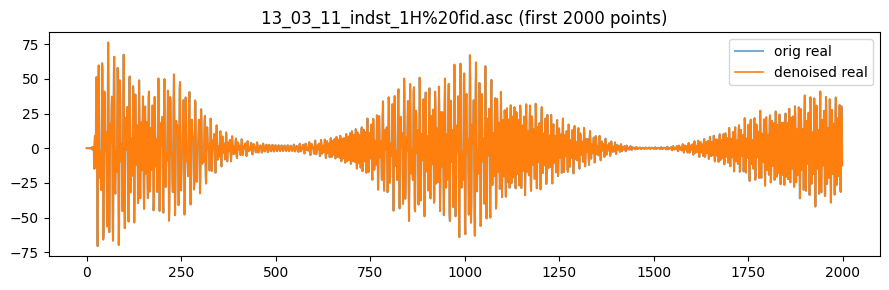


Head → training_data_1.asc
   time_s      real      imag
-2.506402  0.000239 -0.000347
-2.505256 -0.000096 -0.000442
-2.504111  0.000151 -0.000326
-2.502965  0.000271 -0.000359
-2.501820  0.000169 -0.000273
-2.500674  0.000190 -0.000206
-2.499529  0.000040 -0.000213
-2.498383  0.000298 -0.000217
Metrics → MSE=5.287e-06 | SNR orig=8.99 dB | den=9.01 dB | Δ=0.02 dB


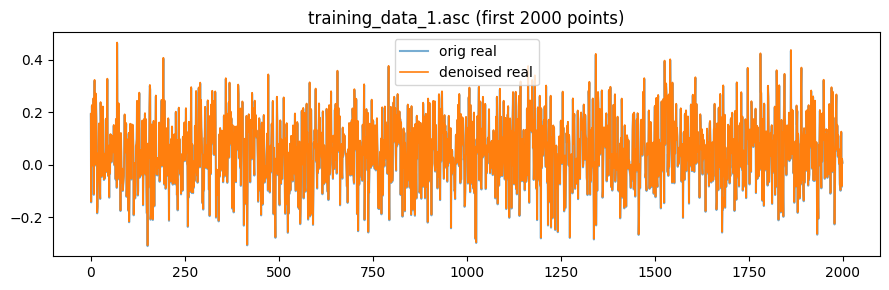


Head → training_data_10.asc
    time_s     real      imag
-24.960218 0.000298  0.000497
-24.950684 0.000636 -0.000015
-24.941151 0.000882  0.000159
-24.931616 0.000667  0.000683
-24.922081 0.000494  0.000222
-24.912546 0.000658  0.000223
-24.903011 0.001162  0.000363
-24.893476 0.001101  0.001547
Metrics → MSE=5.292e-06 | SNR orig=12.29 dB | den=12.29 dB | Δ=0.00 dB


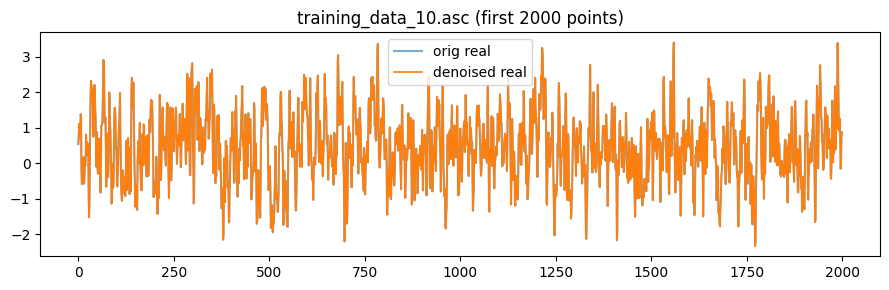


Head → training_data_11.asc
    time_s      real      imag
-24.960218 -0.000707 -0.005553
-24.950684 -0.000659 -0.006422
-24.941151  0.001306 -0.007432
-24.931616  0.004766 -0.006269
-24.922081  0.005264 -0.002406
-24.912546  0.003022 -0.000512
-24.903011  0.001504 -0.001131
-24.893476  0.000707 -0.001353
Metrics → MSE=5.292e-06 | SNR orig=5.12 dB | den=5.12 dB | Δ=-0.00 dB


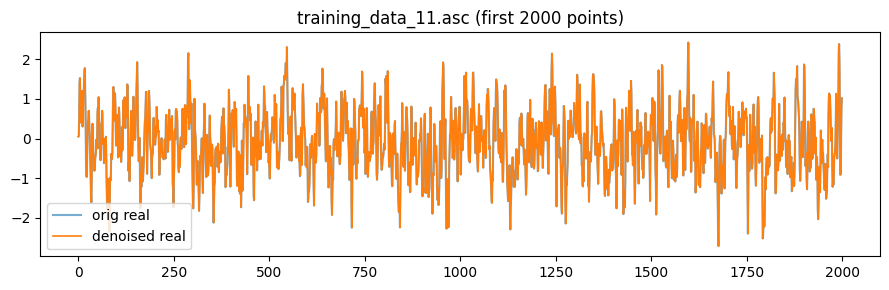


Head → training_data_12.asc
  time_s      real      imag
0.000000  0.000001  0.000013
0.000133 -0.001206 -0.004204
0.000267 -0.015305  0.264425
0.000400 -0.393098  0.597293
0.000533 -0.390635 -0.655285
0.000666 -0.159620  0.535001
0.000800 -0.119189 -1.585681
0.000933  0.777831  0.917124
Metrics → MSE=5.288e-06 | SNR orig=55.98 dB | den=55.98 dB | Δ=-0.00 dB


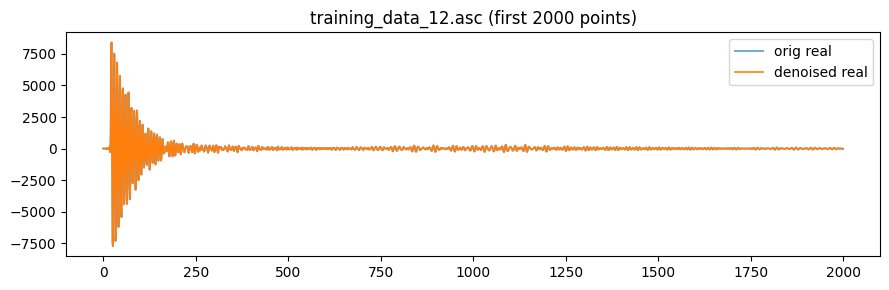


--- Summary ---
                       file     N        dt_s  Acq_time_s   SW_Hz  DR_Hz_per_pt  DR_ppm_per_pt  nyquist_hz  nyquist_ppm     T2_s      ΔSNR_dB
13_03_11_indst_1H%20fid.asc 16384 0.000133276     2.18359 7503.23      0.457961     0.00114553     3751.61      9.38414  3.84895 -2.09808e-05
        training_data_1.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442    0.0176716
       training_data_10.asc 26214  0.00953674     249.996 104.858    0.00400006    1.00056e-05     52.4288     0.131143  12.4989  0.000276566
       training_data_11.asc 26214  0.00953674     249.996 104.858    0.00400006    1.00056e-05     52.4288     0.131143  12.4989 -0.000112534
       training_data_12.asc 16384 0.000133276     2.18359 7503.23      0.457961     0.00114553     3751.61      9.38414  0.23339 -3.05176e-05
       training_data_13.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195  114.792  9

In [17]:

# ---- Helper functions ----
def _read_asc(path):
    arr = np.genfromtxt(path, delimiter=None)
    if arr is None or arr.size == 0:
        raise ValueError(f"Empty or unreadable file: {path}")
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    if arr.shape[1] == 1:
        r = arr[:, 0].astype(np.float32)
        im = np.zeros_like(r, dtype=np.float32)
        t = np.arange(len(r), dtype=np.float32)
    else:
        t = arr[:, 0].astype(np.float32)
        r = arr[:, 1].astype(np.float32)
        im = (arr[:, 2].astype(np.float32) if arr.shape[1] >= 3 else np.zeros_like(r, dtype=np.float32))
    m = np.isfinite(t) & np.isfinite(r) & np.isfinite(im)
    t, r, im = t[m], r[m], im[m]
    if t.size >= 2 and t[1] < t[0]:
        idx = np.argsort(t)
        t, r, im = t[idx], r[idx], im[idx]
    return t, r, im

def _preprocess_pair(real_imag_2xL: np.ndarray, max_gain=1e3):
    sig = real_imag_2xL.astype(np.float32, copy=True)
    L = sig.shape[1]
    if L < 8:
        return sig
    tail = slice(int(0.8 * L), L)
    baseline = sig[:, tail].mean(axis=1, keepdims=True)
    sig -= baseline
    tail_rms = np.sqrt((sig[:, tail] ** 2).mean(axis=1, keepdims=True) + 1e-12)
    tiny = tail_rms < 1e-6
    if np.any(tiny):
        half = slice(int(0.5 * L), L)
        alt_rms = np.sqrt((sig[:, half] ** 2).mean(axis=1, keepdims=True) + 1e-12)
        tail_rms = np.where(tiny, alt_rms, tail_rms)
    gain = np.minimum(1.0 / (tail_rms + 1e-12), max_gain)
    sig = (sig * gain).astype(np.float32)
    return sig

def _denoise(sig_2xL: np.ndarray):
    model_physics.eval()
    with torch.no_grad():
        x = torch.from_numpy(sig_2xL.astype(np.float32)).unsqueeze(0).to(device)   # (1,2,L)
        y = model_physics(x).detach().cpu().squeeze(0).numpy()                     # (2,L)
    return y.astype(np.float32)

def _head_print(t, r, im, rows=8, label=None):
    df = pd.DataFrame({"time_s": t[:rows], "real": r[:rows], "imag": im[:rows]})
    if label: print(f"\n{label}")
    print(df.to_string(index=False))

def _snr_from_env(env):
    L = env.shape[0]
    if L < 16:
        return np.nan
    s0, s1 = 0, int(0.2 * L)
    n0, n1 = int(0.8 * L), L
    sig_rms = np.sqrt(np.mean(env[s0:s1] ** 2) + 1e-12)
    noise_rms = np.sqrt(np.mean(env[n0:n1] ** 2) + 1e-12)
    return 20.0 * np.log10(sig_rms / noise_rms)

def _robust_dt(t):
    if t.size < 2: return np.nan
    d = np.diff(t)
    d = d[np.isfinite(d) & (d > 0)]
    return float(np.median(d)) if d.size else np.nan

@torch.no_grad()
def _estimate_t2_from_pair(pair_2xL, dt, frac=0.25):
    if pair_2xL.shape[1] < 32 or not np.isfinite(dt) or dt <= 0:
        return np.nan
    z = torch.from_numpy(pair_2xL.astype(np.float32))
    r, i = z[0], z[1]
    env = torch.clamp(torch.sqrt(r * r + i * i), min=1e-12)
    n = max(16, int(frac * env.shape[-1]))
    tvec = torch.arange(n, dtype=env.dtype) * dt
    y = torch.log(env[:n])
    A = torch.stack([torch.ones_like(tvec), tvec], dim=1)
    sol = torch.linalg.lstsq(A, y.unsqueeze(1)).solution
    b = float(sol[1])
    return float((-1.0 / b) if b < 0 else (0.2 * n * dt))

# ---- Processing loop ----
rows = []
previewed = improved = processed = saved = 0
max_preview = 5
nu0_Hz = 399.78219838e6

print("[Run] Starting denoise + metrics...")
for fpath in files:
    fname = os.path.basename(fpath)
    try:
        t, r, im = _read_asc(fpath)
        pair = np.stack([r, im]).astype(np.float32)          # (2,L)
        sig = _preprocess_pair(pair)
        den = _denoise(sig)
        env_x = np.sqrt(sig[0]**2 + sig[1]**2)
        env_y = np.sqrt(den[0]**2 + den[1]**2)
        mse = float(np.mean((den - sig)**2))
        snr_x = _snr_from_env(env_x)
        snr_y = _snr_from_env(env_y)
        dsnr = snr_y - snr_x if np.isfinite(snr_x) and np.isfinite(snr_y) else np.nan
        dt_i = _robust_dt(t)
        nyq_hz = (1.0 / (2.0 * dt_i)) if np.isfinite(dt_i) and dt_i > 0 else np.nan
        nyq_ppm = nyq_hz / (nu0_Hz / 1e6) if np.isfinite(nyq_hz) else np.nan
        T2_i = _estimate_t2_from_pair(sig, dt_i if np.isfinite(dt_i) else np.nan)

        if np.isfinite(dsnr) and dsnr > 0.5:
            improved += 1

        if previewed < max_preview:
            _head_print(t, r, im, label=f"Head → {fname}")
            print(f"Metrics → MSE={mse:.3e} | SNR orig={snr_x:.2f} dB | den={snr_y:.2f} dB | Δ={dsnr:.2f} dB")
            early = min(2000, sig.shape[1])
            plt.figure(figsize=(9,3))
            plt.plot(np.arange(early), sig[0,:early], label='orig real', alpha=0.6)
            plt.plot(np.arange(early), den[0,:early], label='denoised real', lw=1.2)
            plt.legend(); plt.title(f"{fname} (first {early} points)"); plt.tight_layout(); plt.show()
            previewed += 1

        if save_outputs:
            out_path = os.path.join(out_dir, os.path.splitext(fname)[0] + "_denoised.asc")
            np.savetxt(out_path,
                       np.column_stack([t, den[0], den[1]]),
                       fmt="%.9g",
                       header="time_s real imag",
                       comments="")
            saved += 1

        # ...existing code...
        Acq_time_s = sig.shape[1] * dt_i if np.isfinite(dt_i) else np.nan
        SW_file_Hz = 1.0 / dt_i if np.isfinite(dt_i) and dt_i > 0 else np.nan
        DR_file_Hz = SW_file_Hz / sig.shape[1] if np.isfinite(SW_file_Hz) else np.nan
        DR_file_ppm = DR_file_Hz / (nu0_Hz / 1e6) if np.isfinite(DR_file_Hz) else np.nan

        rows.append({
            "file": fname,
            "N": sig.shape[1],
            "dt_s": dt_i,
            "Acq_time_s": Acq_time_s,
            "SW_Hz": SW_file_Hz,
            "DR_Hz_per_pt": DR_file_Hz,
            "DR_ppm_per_pt": DR_file_ppm,
            "nyquist_hz": nyq_hz,
            "nyquist_ppm": nyq_ppm,
            "T2_s": T2_i,
            "ΔSNR_dB": dsnr
        })
        # ...existing code...
        processed += 1

    except Exception as e:
        print(f"[Skip] {fname}: {e}")
        continue

summary_df = pd.DataFrame(rows)
print("\n--- Summary ---")
if not summary_df.empty:
    print(summary_df.to_string(index=False,
                               float_format=lambda x: f"{x:.6g}"))
else:
    print("No files processed.")
print(f"\nProcessed: {processed} | Previewed: {previewed} | Improved ΔSNR>0.5: {improved} | Saved: {saved}")

# Quick dtype sanity check
model_dtype = next(iter(model_physics.parameters())).dtype
print(f"[DType] Model params dtype={model_dtype} example signal dtype={sig.dtype}")

### this is important so that our dwell times aren't hard coded

In [18]:
# --- Acquisition parameter setup (run before training & processing) ---
import glob, os, numpy as np, torch

nu0_Hz = 399.78219838e6  # existing base frequency
data_dir = globals().get('data_dir', r"C:\Users\Windows User\NMR-Project\training_data")
files_all = sorted(glob.glob(os.path.join(data_dir, "*.asc")))
if not files_all:
    raise FileNotFoundError(f"No .asc files in {data_dir}")

def _load_time_col(path):
    arr = np.genfromtxt(path, delimiter=None)
    if arr is None or arr.size == 0: return None
    if arr.ndim == 1: arr = arr.reshape(-1,1)
    if arr.shape[1] == 1:
        # no explicit time column → infer uniform spacing from index (assume dt via later median)
        t = np.arange(arr.shape[0], dtype=np.float64)
    else:
        t = arr[:,0]
    t = t[np.isfinite(t)]
    if t.size < 2: return None
    d = np.diff(t)
    d = d[(d > 0) & np.isfinite(d)]
    if d.size == 0: return None
    return np.median(d)

# Collect candidate dts
dts = [dt for f in files_all if (dt := _load_time_col(f)) is not None]
if not dts:
    raise RuntimeError("Could not derive dwell times from files.")
dt_global = float(np.median(dts))  # robust representative dwell time
SW_global_Hz = 1.0 / dt_global
DR_global_Hz = SW_global_Hz / CROP_LEN  # synthetic digital resolution (Hz per point)
DR_global_ppm = DR_global_Hz / (nu0_Hz / 1e6)

print(f"[AcqSetup] dt_global={dt_global:.6g}s SW_global={SW_global_Hz:.6g}Hz "
      f"DR_global={DR_global_Hz:.6g}Hz/pt ({DR_global_ppm:.6g} ppm/pt)")

# Use for training loss if combined_loss expects dt
dt = dt_global  # overwrite previous dt if defined
MODEL_NAME = model_physics.__class__.__name__

# Fid tensor for overfit sanity (first file with usable dt)
first_file = files_all[0]
arr = np.genfromtxt(first_file, delimiter=None)
if arr.ndim == 1: arr = arr.reshape(-1,1)
if arr.shape[1] == 1:
    r = arr[:,0].astype(np.float32); im = np.zeros_like(r, dtype=np.float32)
else:
    r = arr[:,1].astype(np.float32)
    im = (arr[:,2].astype(np.float32) if arr.shape[1] >= 3 else np.zeros_like(r, dtype=np.float32))
fid_tensor = torch.from_numpy(np.stack([r,im])).unsqueeze(0).to(device)
print(f"[AcqSetup] fid_tensor.shape={tuple(fid_tensor.shape)}")

[AcqSetup] dt_global=0.00013328s SW_global=7503Hz DR_global=3.66357Hz/pt (0.00916393 ppm/pt)
[AcqSetup] fid_tensor.shape=(1, 2, 16385)


In [24]:
import importlib, functions.neural_net as nnets
importlib.reload(nnets)
print("combined_loss?", hasattr(nnets, "combined_loss"))
from functions.neural_net import synth_batch_phys, combined_loss
# --- AMP setup (must run before training cell) ---
use_cuda = torch.cuda.is_available()
from torch.cuda.amp import autocast
print(f"[AMP] use_cuda={use_cuda}")

combined_loss? True
[AMP] use_cuda=False


In [34]:
# Training: synthetic curriculum → (optional) real-data fine-tune over ALL .asc files → save checkpoints
import os, glob, numpy as np, torch, math, time
from datetime import datetime

print("\nTraining with combined loss (synthetic curriculum)...")
t0 = time.perf_counter()
for ep in range(EPOCHS):
    model_physics.train()
    running = 0.0
    sn = NOISE_SCHEDULE[min(ep, len(NOISE_SCHEDULE) - 1)]
    for _ in range(STEPS_PER_EPOCH):
        x, y = synth_batch_phys(batch_size=BATCH_SIZE, L=CROP_LEN, snr_std=sn, colored_noise=True)
        opt.zero_grad(set_to_none=True)
        with autocast(enabled=use_cuda):
            pred = model_physics(x)
            loss = combined_loss(pred, y, dt=dt, x_ref=x)
        loss.backward()  # use standard backward to allow grad clipping on CPU
        torch.nn.utils.clip_grad_norm_(model_physics.parameters(), max_norm=1.0)
        opt.step()
        running += float(loss.detach())

    # Validation snapshot vs baseline at target noise
    model_physics.eval()
    with torch.no_grad():
        xv, yv = synth_batch_phys(batch_size=64, L=CROP_LEN, snr_std=NOISE_SCHEDULE[-1], colored_noise=True)
        with autocast(enabled=use_cuda):
            pv = model_physics(xv)
        mse_noisy = torch.mean((xv - yv) ** 2).item()
        mse_pred = torch.mean((pv - yv) ** 2).item()
        snr_impr_db = 20 * math.log10((mse_noisy ** 0.5) / max(mse_pred ** 0.5, 1e-12))
    print(f"epoch {ep+1}: train_loss={running/STEPS_PER_EPOCH:.6f} | val base={mse_noisy:.6f} model={mse_pred:.6f} ΔSNR={snr_impr_db:.2f} dB")

print(f"synthetic train time: {time.perf_counter()-t0:.1f}s")

# ---- Real-data fine-tune on ALL .asc files in training_data (self-denoising) ----
if REAL_FINETUNE_EPOCHS > 0:
    print("\nFine-tuning on real .asc files (self-denoising across entire training_data)...")
    files_ft = sorted(glob.glob(os.path.join(data_dir, "*.asc")))
    # Temporarily lower LR for stability on real data
    old_lr = opt.param_groups[0]['lr']
    for g in opt.param_groups:
        g['lr'] = min(old_lr, 2e-4)
    for ep in range(REAL_FINETUNE_EPOCHS):
        model_physics.train()
        total = 0.0; count = 0
        for f in files_ft:
            t_r, r_r, i_r = _read_asc(f)
            pair = np.stack([r_r, i_r])
            sig_np = _preprocess_pair(pair, max_gain=1e3)  # (2, L) with robust scaling
            x_real = torch.from_numpy(sig_np).float().unsqueeze(0).to(device)
            y_real = x_real  # self-denoising target
            opt.zero_grad(set_to_none=True)
            with autocast(enabled=use_cuda):
                pred = model_physics(x_real)
                loss = combined_loss(pred, y_real, dt=dt, x_ref=x_real)
            # Skip if unstable
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"[Skip unstable] {os.path.basename(f)} loss=NaN/Inf")
                continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_physics.parameters(), max_norm=1.0)
            opt.step()
            total += float(loss.detach()); count += 1
        print(f"real ft epoch {ep+1}: loss={total/max(1,count):.6f} over {count} files")
    # Restore LR
    for g in opt.param_groups:
        g['lr'] = old_lr

# ---- Save checkpoints ----
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
ckpt_path = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_{stamp}.pth")
latest_path = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_latest.pth")
torch.save({'model_state': model_physics.state_dict(), 'config': {
    'EPOCHS': EPOCHS, 'STEPS_PER_EPOCH': STEPS_PER_EPOCH, 'BATCH_SIZE': BATCH_SIZE, 'CROP_LEN': CROP_LEN,
    'NOISE_SCHEDULE': NOISE_SCHEDULE, 'REAL_FINETUNE_EPOCHS': REAL_FINETUNE_EPOCHS
}}, ckpt_path)
torch.save({'model_state': model_physics.state_dict()}, latest_path)
print(f"Saved checkpoints → {ckpt_path} and {latest_path}")

# ---- Overfit a single real FID (sanity check) ----
print("\nOverfitting single real FID (sanity check)...")
model_physics.train()
x_real = fid_tensor.clone()  # (1,2,L)
y_real = x_real.clone()
opt_overfit = torch.optim.Adam(model_physics.parameters(), lr=1e-3)
for i in range(200):
    opt_overfit.zero_grad(set_to_none=True)
    with autocast(enabled=use_cuda):
        pred = model_physics(x_real)
        loss = combined_loss(pred, y_real, dt=dt, x_ref=x_real)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model_physics.parameters(), max_norm=1.0)
    opt_overfit.step()
    if (i + 1) % 50 == 0:
        print(f"step {i+1}: loss={float(loss.detach()):.6e}")

# ---- Inference on real FID + plots ----
model_physics.eval()
with torch.no_grad():
    with autocast(enabled=use_cuda):
        denoised = model_physics(fid_tensor).cpu()  # (1,2,L)

print("\nShapes → input:", tuple(fid_tensor.shape), "denoised:", tuple(denoised.shape))

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title("Real Part of FID")
plt.plot(fid_tensor[0, 0].detach().cpu().numpy(), label="original", alpha=0.6)
plt.plot(denoised[0, 0].detach().cpu().numpy(), label="denoised", lw=1.5)
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Imag Part of FID")
plt.plot(fid_tensor[0, 1].detach().cpu().numpy(), label="original", alpha=0.6)
plt.plot(denoised[0, 1].detach().cpu().numpy(), label="denoised", lw=1.5)
plt.legend()
plt.tight_layout()
plt.show()

print("Done. Trained, fine-tuned on all training_data files, saved checkpoints, overfit sanity check, and plotted results.")


Training with combined loss (synthetic curriculum)...


C:\Users\Windows User\AppData\Local\Temp\ipykernel_29928\2310725812.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_cuda):


RuntimeError: rfft expects a real input tensor, but got ComplexFloat

### Once me and Krish get a spectrum replace this with that FID

Make the FID into a torch instead of a numpy array so that now You can put it into pytorch.

The output says that we are processing 1 FID, we are working with 2 chanels (real vs imaginary) , and the length of that is x (depending on the particular FID)

#### use a bayesian torch here
would using a bayesian model help with the MRSE calcs?

# 🧠 Understanding the Dilated Conv FID Network

## 1️⃣ Parameters (Weights & Biases)

For a Conv1D layer:

$$
\text{Weights shape: } (C_{\text{out}}, C_{\text{in}}, K)
$$

- $C_{\text{in}}$ = input channels  
- $C_{\text{out}}$ = output channels  
- $K$ = kernel size  

**Number of weight parameters:**
$$
N_{\text{weights}} = C_{\text{out}} \times C_{\text{in}} \times K
$$

**Number of bias parameters:**
$$
N_{\text{bias}} =
\begin{cases}
C_{\text{out}} & \text{if bias exists} \\
0 & \text{otherwise}
\end{cases}
$$

**Total parameters per layer:**
$$
N_{\text{params}} = N_{\text{weights}} + N_{\text{bias}}
$$

> Example: First Conv1D: `(32, 2, 7)` → $(32 \times 2 \times 7 = 448)$ weights + 32 biases → 480 total params

---

## 2️⃣ Kernel Intuition

- Kernel = small 1D array of trainable numbers  
- Slides along FID → multiplies & sums → extracts local patterns (peaks, oscillations)  
- Each output channel has its own kernel for every input channel

---

## 3️⃣ Choosing Channels

- Input channels: $C_{\text{in}} = 2$ (Real + Imag FID)  
- Hidden channels: $C_{\text{hidden}} = 32$ (network capacity hyperparameter)  
- Output channels: same as input ($C_{\text{out}} = 2$)  

---

## 4️⃣ Dilation & Effective Kernel

**Dilation** = spacing between kernel elements:

$$
\text{Effective kernel size: } K_{\text{eff}} = D \cdot (K - 1) + 1
$$

- $D$ = dilation factor  
- $K_{\text{eff}}$ = how many original FID points a single output “sees”  
- Cumulative receptive field adds contributions from each layer:  

$$
\text{cum\_RF}_{i} = \text{cum\_RF}_{i-1} + K_{\text{eff}} - 1
$$

> Your network final layer sees 385 points of the original FID.

---

## 5️⃣ Residual Connections

- Each `DilatedResBlock` predicts a **residual**:  

$$
\text{output} = x + \text{residual}(x)
$$

- Helps learning: network focuses on **correcting noise** rather than recreating FID from scratch

---

## 6️⃣ Visual Intuition

- Input: FID `(batch, channels, length)`  
- Layers: conv1 → residual blocks → out  
- Each block expands **receptive field** via dilation  
- Visual: each ■ = output channel  